# Estudio de las Ventas de una Ferretería
## NB2: EDA y Visualización de los Datos

>Autor: Diana Chacón Ocariz

### Contenido

1. [Introducción](#introduccion)
1. [Carga de Librerías](#carga-librerias)
1. [Carga de Datos](#carga-datos)
    1. [Datos Ventas](#datos-ventas)
    1. [Datos Stock](#datos-stock)
    1. [Datos Ventas Línea Producto y Stock](#datos-ventas-stock) 
1. [Funciones Generales](#funciones)
1. [Ventas en USD](#ventas-usd)
    1. [Resumen General](#resumen-general-ventas)
    1. [Ventas Excepcionales](#ventas-excepcionales)
    1. [Ventas por Fecha](#ventas-fechas) 
        1. [Ventas por Día de la Semana](#ventas-dia-semana) 
        1. [Ventas por Día del Mes](#ventas-dia-mes) 
1. [Ventas por Línea de Producto](#ventas-linea)
    1. [Resumen General](#resumen-general-volumen)
    1. [Productos con Ventas Numerosas](#ventas-numerosas)
    1. [Líneas de Producto más vendidas en Volumen](#linea-mas-vendidos)   
1. [Ventas por Producto](#ventas-producto)
    1. [Productos sin Ventas](#prod-sin-ventas)
    1. [Productos más Vendidos](#prod-mas-vendidos)
    1. [Productos Indispensables](#prod-indispensables)
    1. [Productos Rotura Stock](#rotura-stock)   
1. [Afluencia de Clientes](#afluencia-cl)
    1. [Afluencia de Clientes por Día de la Semana](#afluencia-cl-dia)
    1. [Afluencia de Clientes por Hora](#afluencia-cl-hora)
    1. [Conclusiones](#afluencia-cl-conclusion)

## 1. Introducción<a name="introduccion"></a>

Se trata de una pequeña ferretería que maneja un poco más de 3.000 productos distintos. Poseen un software de gestión genérico que les provee una gran cantidad de reportes, básicamente tablas con números, díficiles de analizar (un reporte puede constar de varias decenas de páginas).

**Buscamos tener mayor visibilidad sobre las ventas para poder mejorar el proceso de compras y la toma de decisiones en general:** 

 - Analizar objetivamente las ventas.
 - Identificar los productos más y menos vendidos.
 - Determinar los productos que podrían entrar en rotura de stock al final del período.
 - Saber los momentos de mayor afluencia de clientes.
 - Conocer el mejor vendedor de cada mes.

### ¿Qué nos interesa de los datos?

3 variables nos interesan:
 - **cantidad:** Nos da el volumen de ventas (cantidad de productos vendidos).
 - **monto_dolar:** Nos da las ventas en USD.
 - **num:** Nos permite contar la cantidad de ventas o facturas. Puede dar una idea de la afluencia de clientes.


## 2. Carga de librerías<a name="carga-librerias"></a>

In [1]:
# Librerías utilizadas
# ==============================================================================

# Librerías para el manejo de directorios
import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd

# Librerías para graficar 
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import squarify
from rich_dataframe import prettify
from pprint import pprint as pp
import circlify

%matplotlib inline


## 3. Carga de Datos<a name="carga-datos"></a>

In [2]:
BASE_DIR = Path.cwd()
BASE_DIR

PosixPath('/home/diana/Documentos/Ciencia de Datos/Proyecto Ventas')

### 3.A Datos Ventas<a name="datos-ventas"></a>

**Metadatos ventas.parquet**

Recuperamos los datos (ya limpios) del rchivo **ventas.parquet**:

Cada fila del DF corresponde a un producto dentro de una factura (línea de factura):

    - num: Número o referencia de la factura          
    - fecha_comp: Fecha de la factura, en formato datetime
    - cliente: Código del cliente           
    - vendedor: Código del vendedor           
    - cod: Código del producto              
    - producto: Descripción del producto          
    - cantidad: Cantidad de producto dentro de la factura   
    - monto: Monto en Bs (moneda venezolana) del producto
    - tipo: Tipo de la factura              
    - fecha: Fecha de la factura en formato yyyy-mm-dd       
    - tasa_dolar: Tasa de cambio del día        
    - monto_dolar: Monto en USD del producto
    
**Nota:** Los datos del 2020 sólo corresponden al total de ventas (factura), no tenemos el detalle de los productos

In [3]:
%%time 
df_ventas = pd.read_parquet(f"{BASE_DIR / 'datos/out/ventas.parquet'}", engine='fastparquet')
df_ventas.sample(5)

CPU times: user 3.93 s, sys: 276 ms, total: 4.2 s
Wall time: 4.32 s


,num,fecha_comp,vendedor,monto,tipo,cod,producto,cantidad,fecha,tasa_dolar,monto_dolar
25266,2021-0000000325-fa,2021-01-13 11:16:00,7,3.00,fa,00744,"RIEGO ABRAZADERA PLASTICA 50MM* 3/4"" AGRO/MOM/FP",1.0,2021-01-13,1.464008,2.049169
3155,2020-0000001167-ne,2020-09-01 10:37:00,7,2266650.00,ne,,,0.0,2020-09-01,335669.000000,6.752634
6446,2020-0000004291-ne,2020-12-23 08:35:00,13,21942000.00,ne,,,0.0,2020-12-23,929626.230000,23.603035
38456,2021-0000001891-ne,2021-08-20 08:26:00,11,3.36,ne,00348,"TEE HG 1/2""",1.0,2021-08-20,3.973438,0.845615
11423,2022-0000006628-ne,2022-01-17 08:40:00,13,98.00,ne,01181,R. CAMILLA O CHASIS MOTOR FUMIGAR SENCILLO,1.0,2022-01-17,4.870000,20.123203


In [4]:
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42447 entries, 0 to 42446
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   num          42447 non-null  object        
 1   fecha_comp   42447 non-null  datetime64[ns]
 2   vendedor     42447 non-null  int64         
 3   monto        42447 non-null  float64       
 4   tipo         42447 non-null  object        
 5   cod          42447 non-null  object        
 6   producto     42447 non-null  object        
 7   cantidad     42447 non-null  float64       
 8   fecha        42447 non-null  datetime64[ns]
 9   tasa_dolar   42447 non-null  float64       
 10  monto_dolar  42447 non-null  float64       
dtypes: datetime64[ns](2), float64(4), int64(1), object(4)
memory usage: 3.9+ MB


### 3.B Datos Stock<a name="datos-stock"></a>

**Metadatos stock.parquet**

Recuperamos los datos (ya limpios) del rchivo **stock.parquet**:

Cada fila del DF corresponde a un producto con su stock a una fecha dada:
         
    - cod: Código del producto              
    - producto: Descripción del producto          
    - linea: Línea o categoría del producto  
    - stock: Cantidad del producto en stock              
    - fecha_stock: Fecha del stock, en formato yyyy-mm-dd       

In [5]:
%%time 
df_stock = pd.read_parquet(f"{BASE_DIR / 'datos/out/stock.parquet'}", engine='fastparquet')
df_stock.sample(5)

CPU times: user 11.8 ms, sys: 3.97 ms, total: 15.7 ms
Wall time: 18.7 ms


,cod,producto,linea,stock,fecha_stock
876,00900,LAMPARA 1 LUZ MOVIL METALICA OVALADA NEGRO 6066N,ELECTRICIDAD,1.0,2022-02-16
2651,04574,"TEIPE ELECTRICO 3/4"" TEMFLEX 18.3 METROS 3M",GENERALES,6.0,2022-02-16
1493,01690,"110 BUSINHG 1/2"" * 3/8"" NPT BRONCE M-H",TUBERIA DE COBRE Y CONEXIONES DE BRONCE,12.0,2022-02-16
1228,01281,CONFITERIA CHICLE BON BON BUM,CONEXIONES PLASTICAS DE RIEGO,30.0,2022-02-16
35,00037,CONFITERIA RIKITI CHOCOLATE CON MANI 30GR SAVOY,CHUCHERIAS,11.0,2022-02-16


### 3.C Datos Ventas Línea Producto y Stock<a name="datos-ventas-stock"></a>

Vamos a unir los datos de las Ventas con los del Stock.

Para eso, seleccionamos sólo las ventas a partir le **2021-01-01** ya que para el año 2020 no tenemos el detalle de las ventas. 

Luego, hacemos un merge utilizando el código y la descripción del producto presentes en ambos DF. Hacemos una unión de tipo *Outer* ya que pueden existir productos que no tuvieron ventas y nos interesa tenerlos todos.

In [6]:
# Solo tenemos detalles de ventas a partir de 2021

df_ventas_linea_prod = df_ventas.query('fecha > "2020-12-31"').loc[:,['fecha', 'cod', 'producto', 'cantidad', 'monto_dolar']]
df_ventas_linea_prod.sample(5)

,fecha,cod,producto,cantidad,monto_dolar
26034,2021-01-19,01612,REGULADOR GAS CLIPON CAPACIDAD10KGRS TIPO R1B-...,1.0,15.665148
41986,2021-12-08,00336,"NIPLE PLASTICO 1/2"" * 60 CTM AZUL/GRIS CLASE A",2.0,3.298097
26170,2021-02-19,01902,"MANGUERA 5/16"" TRANSPARENTE CRISTAL POR METRO ...",9.0,2.752223
30226,2021-07-06,00415,"ANILLO HG 1/2""",1.0,0.253117
15494,2022-02-15,00776,BOLSA PLASTICA PEQUEÑA 10KRGS (USO INTERNO) UN...,1.0,0.010893


In [7]:
df_ventas_linea_prod = pd.merge(df_ventas_linea_prod, df_stock, on=['cod', 'producto'], how='outer')
df_ventas_linea_prod

,fecha,cod,producto,cantidad,monto_dolar,linea,stock,fecha_stock
0,2022-01-03,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,1.0,1.842217,GENERALES,15.5,2022-02-16
1,2022-01-03,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,1.0,2.136461,GENERALES,15.5,2022-02-16
2,2022-01-12,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,1.0,2.183168,GENERALES,15.5,2022-02-16
3,2022-01-13,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,1.0,1.822314,GENERALES,15.5,2022-02-16
4,2022-01-17,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,1.0,1.811088,GENERALES,15.5,2022-02-16
...,...,...,...,...,...,...,...,...
32671,NaT,06358,"NIPLE PLASTICO 3/4"" * 1.50 MT AZUL CLASE A",NaN,NaN,"NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS",0.0,2022-02-16
32672,NaT,06360,BOTAS #43 DE CAUCHO VENUS NEGRA,NaN,NaN,SEGURIDAD & HIGIENE,3.0,2022-02-16
32673,NaT,06367,"LLAVE 1/4"" ESFERICA BRONCE MACHO/HEMBRA GRINACA",NaN,NaN,LLAVES O VALVULAS METALICAS,3.0,2022-02-16
32674,NaT,06371,R. VALVULA ENSAMBLADA PARA MOTOR DE FUMIGAR,NaN,NaN,GENERALES,6.0,2022-02-16


## 4. Funciones Generales<a name="funciones"></a>

In [8]:
# Estilo y colores para los gráficos
# ==============================================================================
plt.style.use('seaborn-colorblind')
plt.rcParams['lines.linewidth'] = 1.5

MONTO = '#70c931' 
VOLUMEN = '#2649e8'  
FACTURAS = '#e1db33' 

VERDE = '#99e265' 
AZUL = '#2649e8'  
AMARILLO = '#fff952' 

# Definir colores específicos para cada año
AÑOS = ['2020', '2021', '2022']
COLORES = [VERDE, AZUL, AMARILLO]

In [9]:
# Funciones generales
# ==============================================================================

# Formateado de texto
def formato_titulo(texto):
    subray = '=' * (len(texto))
    print("\033[1;34m"+texto)
    print(subray)
    print("\033[0;m")

In [10]:
# Función para crear gráfico de círculos jerárquicos
# ==============================================================================

def graf_circulos(circles, title):
    # Create just a figure and only one subplot
    fig, ax = plt.subplots(figsize=(14,14))

    # Title
    ax.set_title(title)

    # Remove axes
    ax.axis('off')

    # Find axis boundaries
    lim = max(
        max(
            abs(circle.x) + circle.r,
            abs(circle.y) + circle.r,
        )
        for circle in circles
    )
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)

    # Print circle the highest level (continents):
    for circle in circles:
        if circle.level != 2:
          continue
        x, y, r = circle
        ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="lightblue"))

    # Print circle and labels for the highest level:
    for circle in circles:
        if circle.level != 3:
          continue
        x, y, r = circle
        label = circle.ex["id"]
        ax.add_patch( plt.Circle((x, y), r, alpha=0.5, linewidth=2, color="#69b3a2"))
        plt.annotate(label, (x,y ), ha='center', color="white")

    # Print labels for the continents
    for circle in circles:
        if circle.level != 2:
          continue
        x, y, r = circle
        label = circle.ex["id"]
        plt.annotate(label, (x,y ) ,va='center', ha='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5))


## 5. Ventas en USD<a name="ventas-usd"></a>

### 5.A Resumen General<a name="resumen-general-ventas"></a>

In [11]:
df_ventas.describe()

,vendedor,monto,cantidad,tasa_dolar,monto_dolar
count,42447.000000,4.244700e+04,42447.000000,4.244700e+04,42447.000000
mean,9.489622,1.263125e+06,3.340633,8.427947e+04,9.927922
std,3.425540,1.347791e+07,18.307007,2.062470e+05,51.643987
min,1.000000,1.000000e-02,0.000000,1.178317e+00,0.000317
25%,7.000000,4.255000e+00,0.000000,2.946568e+00,1.095821
50%,10.000000,1.600000e+01,1.000000,4.100000e+00,2.955512
75%,13.000000,4.069502e+04,2.000000,7.088700e+04,7.562262
max,14.000000,1.321200e+09,2000.000000,1.088309e+06,5686.278600


In [12]:
df_ventas_dol = df_ventas.groupby('fecha').monto_dolar.sum().reset_index()
df_ventas_dol.sample(5)

,fecha,monto_dolar
51,2020-03-08,1359.571616
196,2020-10-02,1010.448421
403,2021-06-19,192.499040
351,2021-04-19,527.950956
589,2022-02-01,1775.049041


In [13]:
df_ventas_fecha = df_ventas_dol.set_index('fecha')
df_ventas_fecha.sample(5)

,monto_dolar
fecha,
2020-04-17,1199.526186
2021-06-17,373.483732
2020-11-21,132.302749
2021-07-05,665.648431
2021-07-24,210.075128


In [14]:
# Resumen General de las Ventas en $
# ==============================================================================

total_dias = df_ventas_dol.fecha.nunique()
num_meses = df_ventas_dol.fecha.dt.strftime('%m-%Y').nunique()

max_ventas = df_ventas_dol.monto_dolar.max()
total_ventas = df_ventas_dol.monto_dolar.sum()
promedio_diario =  total_ventas / total_dias
promedio_mensual = total_ventas / num_meses

formato_titulo('Resumen General de las Ventas en $')
print('El período de estudio va de:', df_ventas_dol.fecha.min(), 'a', df_ventas_dol.fecha.max())
print('El total de ventas en $ del período es:', round(total_ventas, 2))
print('El promedio mensual de ventas en $ es:', round(promedio_mensual, 2))
print('El promedio diario es:', round(promedio_diario, 2))
print('El monto máximo de una venta es:', round(max_ventas, 2), 'y es la siguiente:')

df_ventas_dol.query('monto_dolar == monto_dolar.max() ')

Resumen General de las Ventas en $

El período de estudio va de: 2020-01-06 00:00:00 a 2022-02-15 00:00:00
El total de ventas en $ del período es: 421410.5
El promedio mensual de ventas en $ es: 16208.1
El promedio diario es: 700.02
El monto máximo de una venta es: 6058.35 y es la siguiente:


,fecha,monto_dolar
206,2020-10-16,6058.346879


Text(0.5, 0, 'Fecha')

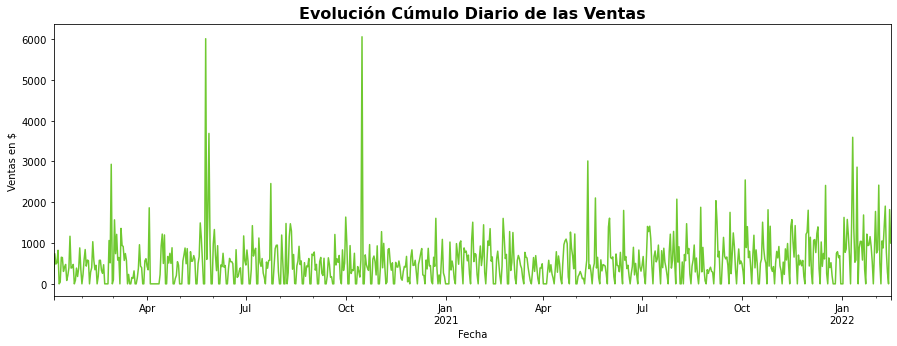

In [15]:
fig, ax = plt.subplots(figsize=(15,5))

df_ventas_fecha.monto_dolar.resample('D').sum().plot(ax=ax, color=MONTO)
ax.set_title('Evolución Cúmulo Diario de las Ventas', fontsize=16, weight='bold')
ax.set_ylabel('Ventas en $')
ax.set_xlabel('Fecha')

In [16]:
# Creamos una columna index para poder hacer un gráfico de regresión y ver la tendencia de las ventas diarias
df_ventas_dol_reg = df_ventas_fecha.monto_dolar.resample('D').sum().reset_index().reset_index()
df_ventas_dol_reg.sample(5)

,index,fecha,monto_dolar
489,489,2021-05-09,0.000000
118,118,2020-05-03,0.000000
188,188,2020-07-12,0.000000
418,418,2021-02-27,0.000000
534,534,2021-06-23,896.239315


Text(0.5, 0, 'N° Días')

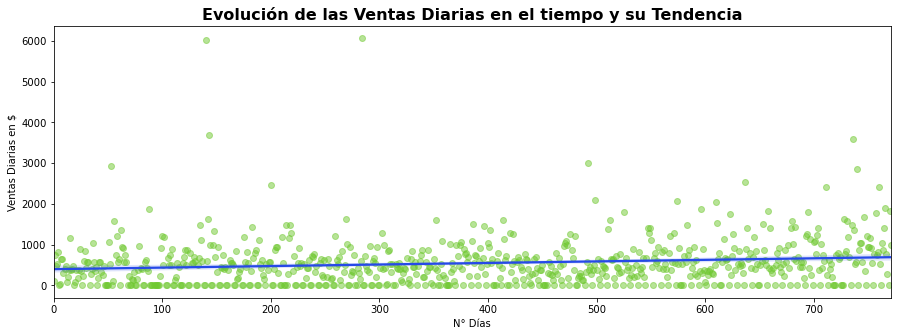

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
sns.regplot(
    x='index',
    y='monto_dolar',
    data=df_ventas_dol_reg,
    scatter_kws={'color': MONTO, 'alpha': 0.5},
    line_kws={'color': AZUL},
)
ax.set_title(
    'Evolución de las Ventas Diarias en el tiempo y su Tendencia',
    fontsize=16,
    weight='bold',
)
ax.set_ylabel('Ventas Diarias en $')
ax.set_xlabel('N° Días')

### 5.B Ventas Excepcionales<a name="ventas-excepcionales"></a>

Las **Ventas Excepcionales** son aquellas cuyos montos son excepcionalmente elevados. Son ventas reales, por lo tanto no pueden ser descartadas completamente.

Estudiarlas, equivale a estudiar los **outliers**.

In [18]:
# Calculamos el monto total por factura

df_total_factura = df_ventas.groupby('num').monto_dolar.sum()
df_total_factura = df_total_factura.reset_index()
df_total_factura.describe()

,monto_dolar
count,25424.000000
mean,16.575303
std,71.387954
min,0.000317
25%,1.913845
50%,4.968520
75%,12.675531
max,5686.278600


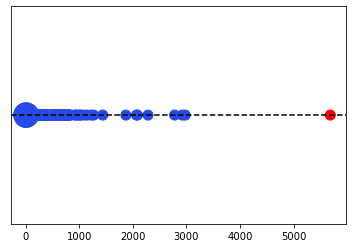

In [19]:
montos = np.array(df_total_factura.monto_dolar)
montos_unicos, counts = np.unique(montos, return_counts=True)
 
sizes = counts*100
colores = [AZUL]*len(montos_unicos)
colores[-1] = 'red'
 
plt.axhline(1, color='k', linestyle='--')
plt.scatter(montos_unicos, np.ones(len(montos_unicos)), s=sizes, color=colores)
plt.yticks([])
plt.show()

<AxesSubplot:xlabel='monto_dolar', ylabel='Density'>

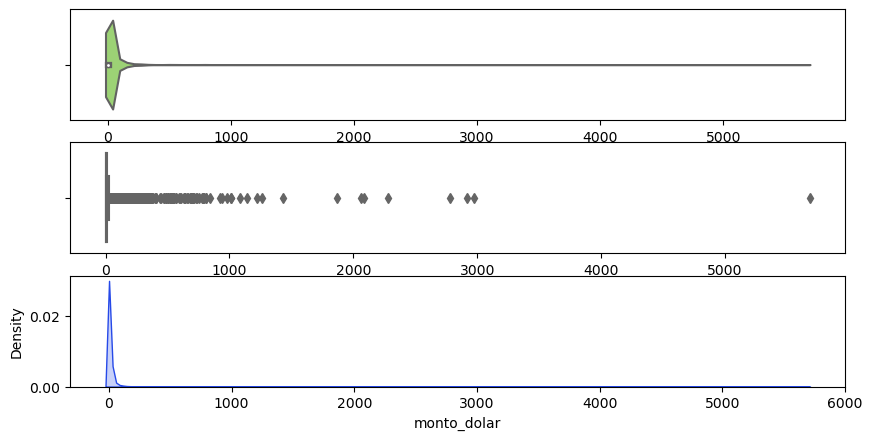

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100, figsize=(10,5))

sns.violinplot(x='monto_dolar', data=df_total_factura, color=VERDE, ax=ax1)
sns.boxplot(x='monto_dolar', data=df_total_factura, color=AMARILLO, ax=ax2)
sns.kdeplot(x='monto_dolar', data=df_total_factura, color=AZUL, shade=True, ax=ax3)

In [21]:
df_total_factura_max = df_total_factura.query('monto_dolar > 1000.0')
df_total_factura_max.describe()

,monto_dolar
count,15.000000
mean,2055.794947
std,1225.904000
min,1015.451327
25%,1180.511252
50%,1866.830040
75%,2529.610593
max,5686.278600


1. La gran mayoría de las ventas no sobrepasa los 13 USD
2. Se observa un grupo que va hasta los 1.000 USD, luego dos pequeños grupos al rededor de los 2.000 USD y 3.000 USD
3. Hay un caso extremo que sobrepasa los 5.680 USD
4. Hay apenas 15 ventas con montos mayores a 1.000 USD, lo que equivale a 0,06% de las ventas. Haremos comparaciones entre los datos completos y los datos sin las ventas mayores a 1.000 USD

In [22]:
df_ventas_sin_excep = df_ventas[~df_ventas.num.isin(df_total_factura_max.num)].loc[:,['fecha', 'monto_dolar']]
df_ventas_sin_excep = df_ventas_sin_excep.groupby('fecha').monto_dolar.sum().reset_index()
df_ventas_sin_excep.sample(5)

,fecha,monto_dolar
440,2021-08-02,2076.398369
599,2022-02-12,283.179266
142,2020-07-21,383.261152
491,2021-10-04,1464.929440
209,2020-10-21,387.718568


In [23]:
df_ventas_comparacion = pd.merge(df_ventas_dol, df_ventas_sin_excep, on='fecha')
df_ventas_comparacion.columns=['fecha', 'monto_dolar', 'monto_sin_ex']
df_ventas_comparacion = df_ventas_comparacion.set_index('fecha')
df_ventas_comparacion.sample(5)

,monto_dolar,monto_sin_ex
fecha,,
2021-03-12,379.055289,379.055289
2020-02-05,434.875294,434.875294
2021-07-28,385.835484,385.835484
2020-12-15,365.142606,365.142606
2021-06-28,829.151021,829.151021


Text(0, 0.5, 'Sin Ventas Excepcionales')

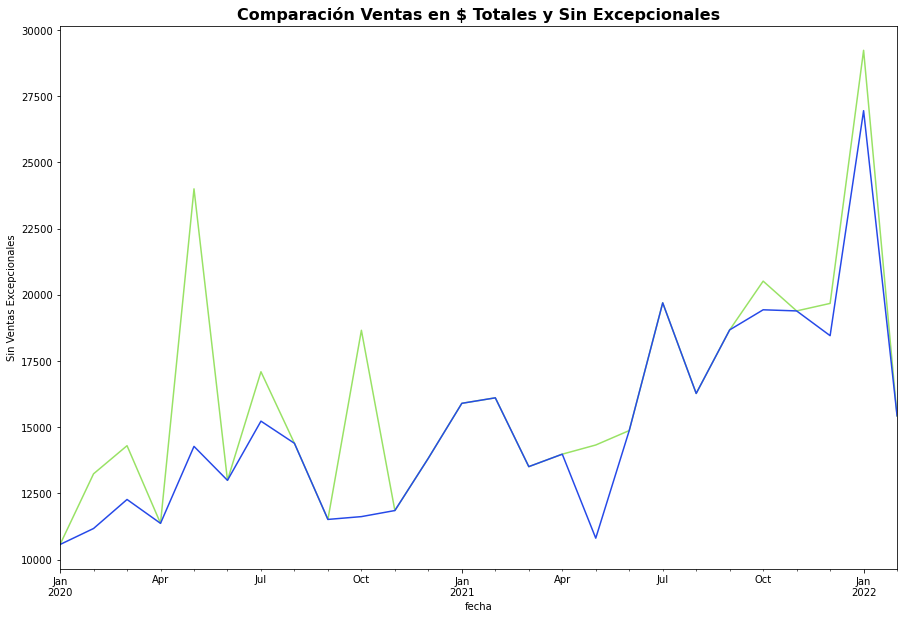

In [24]:
fig, ax = plt.subplots(figsize=(15,10))

df_ventas_comparacion.monto_dolar.resample('M').sum().plot(color=VERDE)
df_ventas_comparacion.monto_sin_ex.resample('M').sum().plot(color=AZUL)
ax.set_title('Comparación Ventas en $ Totales y Sin Excepcionales', fontsize=16, weight='bold')
ax.set_ylabel('Ventas Totales')
ax.set_ylabel('Sin Ventas Excepcionales')

In [25]:
df_ventas_comparacion.reset_index(inplace=True)

In [26]:
# Comparación total de ventas por año tomando en cuenta o no las ventas excepcionales

df_comparacion_año = df_ventas_comparacion.pivot_table(index=df_ventas_comparacion.fecha.dt.year,
                            aggfunc={'monto_dolar': sum, 'monto_sin_ex': sum})
df_comparacion_año['diferencia'] = df_comparacion_año.monto_dolar - df_comparacion_año.monto_sin_ex
df_comparacion_año.columns = ['Todas las Ventas', 'Sin Excepcionales', 'Diferencia']
df_comparacion_año

,Todas las Ventas,Sin Excepcionales,Diferencia
fecha,,,
2020,173810.250632,151076.476739,22733.773893
2021,202934.058353,197111.846817,5822.211535
2022,44666.191630,42385.252855,2280.938776


### 5.C Ventas por Fecha<a name="ventas-fecha"></a>

In [27]:
# Calculamos diferentes partes de la fecha

df_ventas_dol['año'] = df_ventas_dol.fecha.dt.year
df_ventas_dol['mes_año'] = df_ventas_dol.fecha.dt.strftime('%m-%Y')
df_ventas_dol['dia_semana'] = df_ventas_dol.fecha.dt.weekday
df_ventas_dol['dia_mes'] = df_ventas_dol.fecha.dt.day
df_ventas_dol.sample(5)

,fecha,monto_dolar,año,mes_año,dia_semana,dia_mes
130,2020-07-06,357.390229,2020,07-2020,0,6
439,2021-07-31,553.106954,2021,07-2021,5,31
388,2021-06-02,645.720572,2021,06-2021,2,2
526,2021-11-15,1412.320796,2021,11-2021,0,15
361,2021-04-30,1222.950739,2021,04-2021,4,30


In [28]:
lineas = alt.Chart(df_ventas_dol).mark_bar().encode(
    x='month(fecha):T',
    y='sum(monto_dolar):Q',
    color=alt.Color('año:N', scale=alt.Scale(domain=AÑOS, range=COLORES)),
    tooltip=[
        alt.Tooltip('yearmonth(fecha):T', title='Fecha'),
        alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $'),
    ]).properties(width=800, height=200)

lineas

alt.Chart(...)

In [29]:
barras = alt.Chart(df_ventas_dol).mark_bar().encode(
                x=alt.X('yearmonth(fecha):T', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('sum(monto_dolar):Q', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('yearmonth(fecha):T', title='Día'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')],
                ).properties(title='Ventas en $ por Mes',
                             width=700, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()
barras

alt.Chart(...)

#### 5.C.a Ventas por Día de la Semana<a name="ventas-dia-semana"></a>

In [30]:
# Total de ventas por día de la semana de cada mes

df_ventas_dia_semana = df_ventas_dol.pivot_table(index=df_ventas_dol.mes_año,
                                            columns=df_ventas_dol.dia_semana, aggfunc={'monto_dolar': sum},
                                            fill_value=0)
df_ventas_dia_semana.columns = ['Lun', 'Mar', 'Mie', 'Jue', 'Vie', 'Sab', 'Dom']
df_ventas_dia_semana

,Lun,Mar,Mie,Jue,Vie,Sab,Dom
mes_año,,,,,,,
01-2020,1531.657232,2730.974894,1557.202647,2207.919301,2123.907868,82.358816,333.857234
01-2021,2950.556683,4039.964339,2166.060704,2864.239439,2884.332234,996.294727,0.000000
01-2022,5993.008193,6345.862615,4211.000312,3849.191008,4383.430025,4456.175386,0.000000
02-2020,1563.447720,2453.311830,2397.020698,1701.697084,4424.442111,0.000000,697.923364
02-2021,1559.886233,3585.569561,3141.892730,3451.844984,3229.538314,1140.054082,0.000000
02-2022,2873.550108,3654.834301,2158.494767,2736.881423,3200.416835,803.346657,0.000000
03-2020,3220.645464,2652.192226,2903.512438,1892.565451,1937.839969,0.000000,1693.889650
03-2021,3298.064658,2713.807813,2568.880136,2812.007238,1635.795558,480.829274,0.000000
04-2020,1027.444224,1645.236462,2942.525720,1801.916525,3949.732841,0.000000,0.000000


In [31]:
mapa = alt.Chart(df_ventas_dol).mark_rect().encode(
                x=alt.X('day(fecha):T', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('yearmonth(fecha):T', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color('sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('day(fecha):T', title='Día'),
                    alt.Tooltip('yearmonth(fecha):T', title='Mes y Año'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')]
                ).properties(title='Ventas en $ por Día de la Semana',
                             width=600, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()

mapa

alt.Chart(...)

In [32]:
barras = alt.Chart(df_ventas_dol).mark_bar().encode(
                x=alt.X('day(fecha):T', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('sum(monto_dolar):Q', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('day(fecha):T', title='Día'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')],
                ).properties(title='Ventas en $ por Día de la Semana',
                             width=600, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()
barras

alt.Chart(...)

#### 5.C.b Ventas por Día del Mes<a name="ventas-dia-mes"></a>

In [33]:
df_ventas_dia_mes = df_ventas_dol.pivot_table(index=df_ventas_dol.mes_año,
                                            columns=df_ventas_dol.dia_mes, aggfunc={'monto_dolar': sum},
                                            fill_value=0)
df_ventas_dia_mes

monto_dolar                                                      \
dia_mes           1            2            3            4            5    
mes_año                                                                    
01-2020     0.000000     0.000000     0.000000     0.000000     0.000000   
01-2021     0.000000     0.000000     0.000000     0.000000  1025.174371   
01-2022     0.000000     0.000000  1628.923241   773.260504   854.500000   
02-2020     0.000000   228.427405   591.898212   840.911939   434.875294   
02-2021   597.742987   928.112308   448.788414   676.658349  1448.390864   
02-2022  1775.049041   757.390192   831.203863  2420.160870   520.167391   
03-2020   102.471183  1569.100584   740.156960  1213.586690   581.002611   
03-2021  1282.797023   327.117997   521.856075  1258.638821   606.867712   
04-2020   429.947573   343.727378  1865.040038     0.000000     0.000000   
04-2021     0.000000     0.000000     0.000000     0.000000   310.550924   
05-2020     0.000000     0.000000     0.000000   559.629421   708.440722   
05-2021     0.000000     0.000000   179.121985   229.004501   303.164561   
06-2020   984.311972  1332.024144   696.307495   323.136042   935.775980   
06-2021  1610.459773   645.720572   618.434072   660.443987   176.276599   
07-2020   460.703161   830.441806   554.543131     0.000000     0.000000   
07-2021   449.820795   670.552823   205.902734     0.000000   665.648431   
08-2020     0.000000     0.000000  1197.170954   556.828608     0.000000   
08-2021     0.000000  2076.398369   532.983106   908.458977     0.000000   
09-2020   696.059023   780.140801   336.050436   478.429830     0.000000   
09-2021   351.150160   407.752358   306.196339   286.529001     0.000000   
10-2020  1637.070887  1010.448421     0.000000     0.000000   938.159789   
10-2021   489.654244   302.497817     0.000000  2547.654501   889.681818   
11-2020     0.000000   421.493914  1279.945126   393.706990   992.169576   
11-2021   511.719101   795.961538   634.821670   915.937639   444.185268   
12-2020   834.225726   450.752098   456.728855   577.661259   289.318192   
12-2021  1804.950207   437.373695  1142.676471   262.088050     0.000000   

                                                                          ...  \
dia_mes           6            7            8            9            10  ...   
mes_año                                                                   ...   
01-2020   104.610817   739.473869   485.385935   515.495960   823.755195  ...   
01-2021   338.556452   559.099981   406.877705   113.560197     0.000000  ...   
01-2022  1579.416327  1191.730392   698.201474     0.000000  1482.000000  ...   
02-2020   582.694724   568.515668     0.000000   288.046326   395.750196  ...   
02-2021   285.706649     0.000000   528.333392  1052.128996   945.011517  ...   
02-2022     0.000000  1052.950108   879.565217  1401.104575  1905.677560  ...   
03-2020   646.227529     0.000000  1359.571616   940.063855   918.230849  ...   
03-2021   138.317334     0.000000   566.644612   696.262891   616.013044  ...   
04-2020     0.000000     0.000000     0.000000     0.000000     0.000000  ...   
04-2021   577.616637   288.305906   468.976941   244.816049   144.322024  ...   
05-2020   878.469839   492.796971   864.247780     0.000000     0.000000  ...   
05-2021   229.910797   125.169426   138.451233     0.000000   337.713740  ...   
06-2020     0.000000     0.000000   462.697836   422.152875   749.672755  ...   
06-2021     0.000000   732.745323   457.801844   438.424317   296.985811  ...   
07-2020   357.390229  1427.228788   680.721010   798.203946   871.979596  ...   
07-2021  1407.765877  1281.355950  1413.361915  1104.303772   448.666178  ...   
08-2020     0.000000  1479.949875     0.000000   276.899321  1156.194226  ...   
08-2021     0.000000   536.191117     0.000000   720.760998   567.037550  ...   
09-2020     0.000000   543.376057   648.269859   256.875271   204.540011  ...   
09-2021   493.153545  

In [34]:
mapa = alt.Chart(df_ventas_dol).mark_rect().encode(
                x=alt.X('dia_mes:O', title='Días del mes', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('yearmonth(fecha):T', title = 'Mes y Año', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('dia_mes:O', title='Día'),
                    alt.Tooltip('yearmonth(fecha):T', title='Mes y Año'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $'),
                    alt.Tooltip('cantidad:Q', title='Volumen de Venta'),
                    alt.Tooltip('num:Q', title='N° Facturas')]
                ).properties(title='Ventas en $ por Día del Mes',
                             width=800, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()

mapa

alt.Chart(...)

In [35]:
barras = alt.Chart(df_ventas_dol).mark_bar().encode(
                x=alt.X('dia_mes:O', title='Días de la Semana', axis = alt.Axis(labelAngle=0, labelFontSize=14)),
                y=alt.Y('sum(monto_dolar):Q', title = 'Ventas en $', scale=alt.Scale(zero=False), 
                  axis = alt.Axis(grid=True, titleAnchor='middle', titleAngle = 270, labelFontSize=10)),
                color=alt.Color(
                    'sum(monto_dolar):Q', scale=alt.Scale(scheme='goldgreen')),
                tooltip=[
                    alt.Tooltip('dia_mes:O', title='Día'),
                    alt.Tooltip('sum(monto_dolar):Q', title='Ventas en $')],
                ).properties(title='Ventas en $ por Día del Mes',
                             width=800, 
                             height=300
                ).configure_title(
                    fontSize = 16,
                    anchor = 'middle',
                ).interactive()
barras

alt.Chart(...)

### 5.D Conclusión<a name="ventas-conclusion"></a>

    1) En promedio de venden 409 productos cada día
    2) El promedio de ventas diario es de 673 dólares
    3) 41 es el promedio de facturas que se hacen diariamente
    4) Se nota un incremento de las ventas a partir del 2do semestre del 2021
    5) Entre marzo y junio de 2021 se resgistraron la menor cantidad de ventas del período estudiado

## 6. Ventas por Línea de Producto<a name="ventas-linea"></a>

In [36]:
df_linea = df_ventas_linea_prod.copy()
df_linea['mes_año'] = df_linea.fecha.dt.strftime("%m-%Y")
df_linea.dropna(inplace=True)
df_linea

,fecha,cod,producto,cantidad,monto_dolar,linea,stock,fecha_stock,mes_año
0,2022-01-03,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,1.0,1.842217,GENERALES,15.5,2022-02-16,01-2022
1,2022-01-03,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,1.0,2.136461,GENERALES,15.5,2022-02-16,01-2022
2,2022-01-12,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,1.0,2.183168,GENERALES,15.5,2022-02-16,01-2022
3,2022-01-13,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,1.0,1.822314,GENERALES,15.5,2022-02-16,01-2022
4,2022-01-17,00001,PEGA DE CONTACTO/PEGA ZAPATERA (90 ML) ENVASADO,1.0,1.811088,GENERALES,15.5,2022-02-16,01-2022
...,...,...,...,...,...,...,...,...,...
31448,2021-10-02,04547,"MANDRIL TALADRO 10MM DRILL CHUNK (TALADRO 3/8"")",1.0,4.585153,HERRAMIENTAS ELECTRICAS,2.0,2022-02-16,10-2021
31449,2021-10-02,05666,"GUARDACABO ZINCADO 12mm 1/2"" NACIONAL",2.0,3.441048,GENERALES,4.0,2022-02-16,10-2021
31450,2021-11-24,00910,FREGADERO 100*50/94*48 SOBREPONER ESCURRIDOR I...,1.0,36.082474,GRIFERIA GENERAL,3.0,2022-02-16,11-2021
31451,2021-11-24,05435,"JUNTA DRES 3""*20CM LARGA CON TORNILLOS HIERRO ...",2.0,109.381443,GENERALES,4.0,2022-02-16,11-2021


In [37]:
# Por cada línea de producto: Ventas en volumen (cantidad), N° de productos (producto) 
# y total de Ventas en $ (monto_dolar)
df_linea_general = df_linea.pivot_table(index='linea',
                                        aggfunc={'monto_dolar':sum,
                                                 'producto':'nunique',
                                                 'cantidad':sum})
# Definimos la columna rango para seleccionar las 15 líneas con más ventas en $ y/o volumen
df_linea_general['rango'] = df_linea_general.cantidad + df_linea_general.monto_dolar

df_linea_general.cantidad = round(df_linea_general.cantidad, 2)
df_linea_general.monto_dolar = round(df_linea_general.monto_dolar, 2)

df_linea_general.columns=['Volumen Ventas', 'Ventas en $', 'N° Productos', 'rango']

df_linea_general = df_linea_general.sort_values(['rango'], ascending=False)

table = prettify(df_linea_general, row_limit=45, col_limit=4, delay_time=1)

Output()

In [38]:
df_linea_top_15 = df_linea_general.reset_index().sort_values(['rango'], ascending=False).head(15)


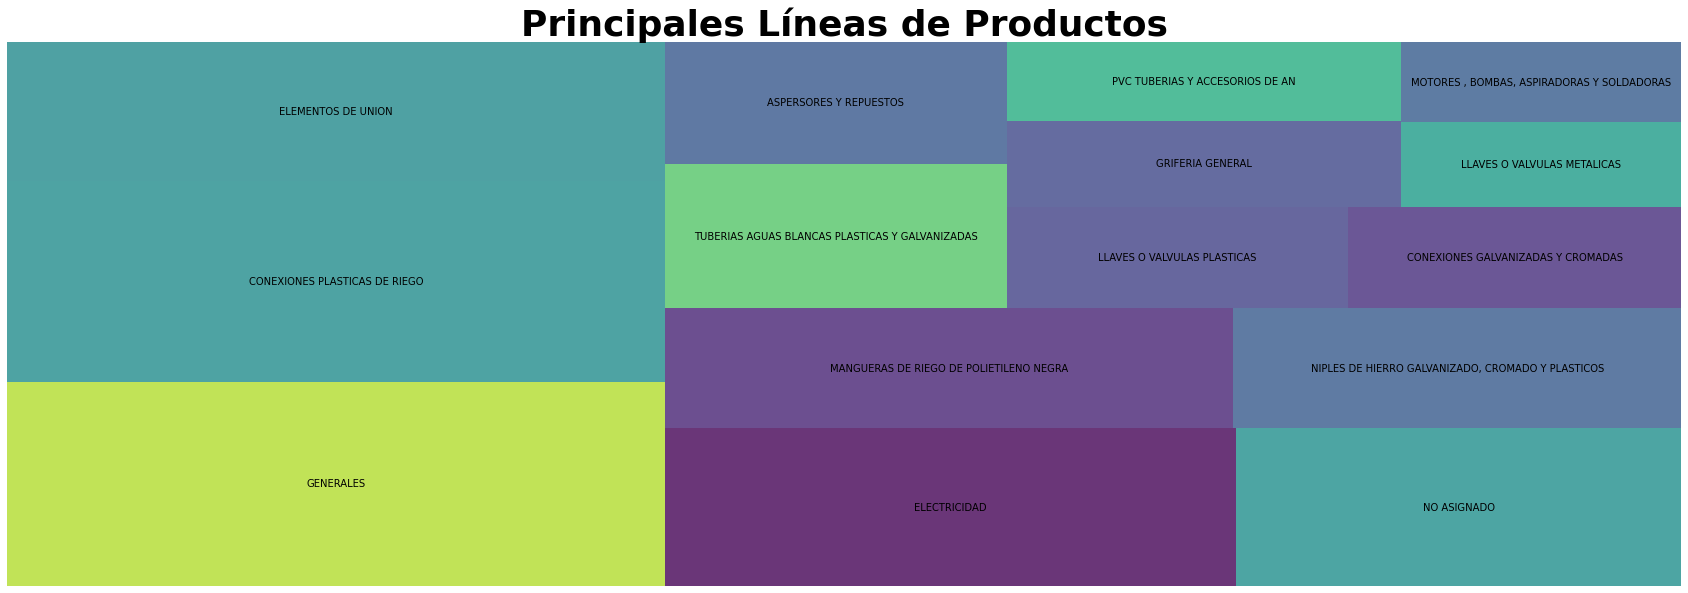

In [39]:
with plt.style.context('seaborn-colorblind'):

    fig, ax = plt.subplots(figsize=(30,10))

    labels = df_linea_top_15['linea']
    sizes = df_linea_top_15['rango']
    squarify.plot(sizes, label=labels, alpha=0.8)

    plt.title('Principales Líneas de Productos',fontsize=36, fontweight='bold') 
    plt.axis('off')
    plt.show()

In [40]:
base = alt.Chart(df_linea_top_15).encode(
    theta=alt.Theta("rango:Q", stack=True), color=alt.Color("linea:N")
)

pie = base.mark_arc(outerRadius=180)
text = base.mark_text(radius=180, size=10).encode(text="linea:N")

pie + text

alt.LayerChart(...)

In [41]:
# Los 5 productos con mayores ventas en $ por cada línea

df_ventas_linea_mont = df_linea.pivot_table(index=['linea', 'producto'],
                                       aggfunc={'monto_dolar':sum})

df_ventas_linea_mont = df_ventas_linea_mont.monto_dolar.groupby('linea', group_keys=False)

df_ventas_linea_mont = df_ventas_linea_mont.nlargest(5)

df_ventas_linea_mont = df_ventas_linea_mont.reset_index()

#df_ventas_linea_mont = df_ventas_linea_mont.set_index('linea')

df_ventas_linea_mont

,linea,producto,monto_dolar
0,ALAMBRES Y MALLAS,ALAMBRE C-17.5 LISO HG KILOGRAMO VICSON,870.014051
1,ALAMBRES Y MALLAS,ALAMBRE DE PUAS CALIBRE 16 400 MTRS TREXA,302.372590
2,ALAMBRES Y MALLAS,ALAMBRE DE PUAS CALIBRE 15.5 METROS 500 IMPORTADO,260.299266
3,ALAMBRES Y MALLAS,ALAMBRE DE PUAS CALIBRE 15 METROS 500 MOTTO VI...,192.911705
4,ALAMBRES Y MALLAS,ALAMBRE DE PUAS CALIBRE 16.5 MOTTO 400 METROS ...,162.654551
...,...,...,...
155,TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS,"ANILLO REDUCIDO 3/4""*1/2"" PLASTICO ROSCADO BLA...",1254.243099
156,TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS,"TUBO PLASTICO 3/4""*6MTS AZUL SHEDULE INPLAVEN",1244.181301
157,TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS,"TUBO PLASTICO 1/2""*6MTS AZUL SHEDULE INPLAVEN",1210.948607
158,TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS,"TUBO PLASTICO 1""*6MTS AZUL SCHEDULE INPLAVEN",719.424858


In [42]:
js = df_ventas_linea_mont.to_json(orient = 'records', indent=2)
d = df_ventas_linea_mont.set_index('linea').T.to_dict('records')

print(d)

[{'ALAMBRES Y MALLAS': 'ALAMBRE DE PUAS CALIBRE 16.5 MOTTO 400 METROS VICKSON', 'ASPERSORES Y REPUESTOS': 'REGADOR 3/4" PLASTICO HEMBRA NEGRO CON AZUL AQUA FINA 5035 DIAMETRO:24 MTRS', 'CABULLAS': 'MECATE ELEFANTE 1/4" #6 1KG MIDE 50MTS (ROLLO 500MTS - 10KG) POR KILO', 'CHUCHERIAS': 'CONFITERIA CARAMELO CHAO/ LOKIÑO/ MIST', 'CONEXIONES GALVANIZADAS Y CROMADAS': 'UNION PATENTE HG 2" 1113 GR', 'CONEXIONES PLASTICAS DE RIEGO': 'ANILLO 3/4" PLASTICO ROSCADO', 'CONSTRUCCIÓN': 'CABILLA 5.5MM*6MTS ESTRIADA TRIPA DE POLLO (POR UNIDAD)', 'DISCOS': 'DISCO 7" CORTE DE CONCRETO SEGMENTADO/TURBO  EXXEL', 'DISPONIBLE': 'DUCHA 1/2" TELEFONO BM MONOMANDO ACABADO CROMO TOKIO', 'ELECTRICIDAD': 'CALENTADOR ELECTRICO RECORD DE 27 LTS', 'ELEMENTOS DE UNION': 'ARANDELA PLANA 3/8" NACIONAL TANQUE AUSTRALIANO', 'GENERALES': 'PEGA 1/4G 946CM3 CPVC PEGA SOLD', 'GRIFERIA GENERAL': 'GRIFERIA LAVAMANOS LLAVE SAM MANILLA AMERICANA 4" INDIVIDUAL', 'GUAYAS': 'GUAYA DESTAPA CAÑO 3M', 'HERRAMIENTA NEUMATICA': 'ACOPLE 1

/tmp/ipykernel_7257/540015411.py:2: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  d = df_ventas_linea_mont.set_index('linea').T.to_dict('records')


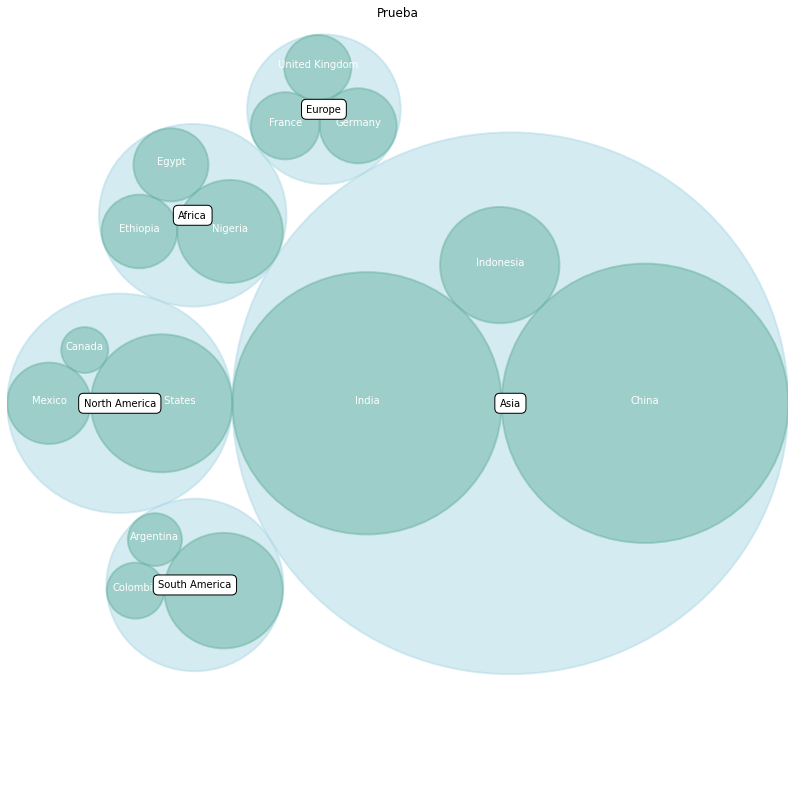

In [43]:
data = [{'id': 'World', 'datum': 6964195249, 'children' : [
              {'id' : "North America", 'datum': 450448697,
                   'children' : [
                     {'id' : "United States", 'datum' : 308865000},
                     {'id' : "Mexico", 'datum' : 107550697},
                     {'id' : "Canada", 'datum' : 34033000} 
                   ]},
              {'id' : "South America", 'datum' : 278095425, 
                   'children' : [
                     {'id' : "Brazil", 'datum' : 192612000},
                     {'id' : "Colombia", 'datum' : 45349000},
                     {'id' : "Argentina", 'datum' : 40134425}
                   ]},
              {'id' : "Europe", 'datum' : 209246682,  
                   'children' : [
                     {'id' : "Germany", 'datum' : 81757600},
                     {'id' : "France", 'datum' : 65447374},
                     {'id' : "United Kingdom", 'datum' : 62041708}
                   ]},
              {'id' : "Africa", 'datum' : 311929000,  
                   'children' : [
                     {'id' : "Nigeria", 'datum' : 154729000},
                     {'id' : "Ethiopia", 'datum' : 79221000},
                     {'id' : "Egypt", 'datum' : 77979000}
                   ]},
              {'id' : "Asia", 'datum' : 2745929500,  
                   'children' : [
                     {'id' : "China", 'datum' : 1336335000},
                     {'id' : "India", 'datum' : 1178225000},
                     {'id' : "Indonesia", 'datum' : 231369500}
                   ]}
    ]}]

circles = circlify.circlify(
    data, 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)
graf_circulos(circles, 'Prueba')

In [44]:
# Los 5 productos con mayores volúmenes de venta por cada línea

df_ventas_linea_cant = df_linea.pivot_table(index=['linea', 'producto'],
                                       aggfunc={'cantidad':sum} )

df_ventas_linea_cant = df_ventas_linea_cant.cantidad.groupby('linea', group_keys=False)

df_ventas_linea_cant = df_ventas_linea_cant.nlargest(5)

df_ventas_linea_cant = df_ventas_linea_cant.reset_index()

df_ventas_linea_cant.set_index('linea', inplace=True)

df_ventas_linea_cant

,producto,cantidad
linea,,
ALAMBRES Y MALLAS,ALAMBRE C-17.5 LISO HG KILOGRAMO VICSON,212.25
ALAMBRES Y MALLAS,"MALLA METALICA GALLINERA 2"" *1.65 *30 C-22 (...",62.40
ALAMBRES Y MALLAS,"MALLA METALICA POLLITO 1"" *0.9*25 C-22 (POR M...",57.90
ALAMBRES Y MALLAS,ALAMBRE C-17.5 LISO HG KILOGRAMO IMPORTADO,41.00
ALAMBRES Y MALLAS,MALLA PLASTICA MOSQUITERO 1.03 MTRS *30MTS GRI...,17.62
...,...,...
TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS,"ANILLO 1/2"" PLASTICO ROSCADO BLANCO",1361.00
TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS,"ANILLO REDUCIDO 1"" * 3/4"" PLASTICO ROSCADO BLANCO",472.00
TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS,"BUSINHG PLASTICO REDUCIDO 3/4"" * 1/2"" AZUL/BL...",237.00


### 6.A Resumen General<a name="resumen-general-volumen"></a>

### 6.B Productos con Ventas Numerosas<a name="ventas-numerosas"></a>

### 6.C Líneas de Producto más vendidas en Volumen<a name="linea-mas-vendidos"></a>

## 7. Ventas por Producto<a name="ventas-producto"></a>

In [75]:
df_ventas_prod = df_ventas_linea_prod.copy()
df_ventas_prod.sample(5)

,fecha,cod,producto,cantidad,monto_dolar,linea,stock,fecha_stock
16639,2021-05-28,03332,"NIPLE PLASTICO 1"" * 15CMS/6""",4.0,6.080416,"NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS",38.0,2022-02-16
21748,2021-09-23,01229,"TEE PLASTICA 1/2"" BLANCA",5.0,3.193876,TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS,142.0,2022-02-16
7039,2021-08-24,03168,"NIPLE HG 1/2"" * 10 CTM/4""",2.0,1.790000,"NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS",424.0,2022-02-16
22912,2021-02-04,01006,"PVC ANILLO REDUCIDO 110MM/4""X50MM/2"" AGUAS NEG...",1.0,0.798975,PVC TUBERIAS Y ACCESORIOS DE AN,58.0,2022-02-16
26486,2021-01-22,00802,"TEIPE ELECTRICO 3/4""*10MTS NEGRO COBRA ORIGINAL",1.0,0.940648,NO ASIGNADO,0.0,2022-02-16


### 7.A Productos sin Ventas<a name="prod-sin-ventas"></a>

In [45]:
# Productos sin ventas
filtro = df_ventas_linea_prod['cantidad'].isna() & df_ventas_linea_prod['stock'] > 0

df_ventas_linea_prod[filtro][ ['linea', 'cod', 'producto', 'stock'] ].sort_values('stock', ascending=False)

,linea,cod,producto,stock
31722,ASPERSORES Y REPUESTOS,00844,R. ACOPLE RAB DOBLE BAJO PARA MICROASPERSOR,8045.00
31723,ASPERSORES Y REPUESTOS,00845,R. ACOPLE RAB LISO ALTO PARA MICROASPERSOR,7600.00
32116,ELEMENTOS DE UNION,03466,"TORNILLO DRYWALL Nº 6 * 1""",3465.00
31725,MANGUERAS GENERALES NO DE POLIETILENO,00847,MANGUERA 7MM PARA MICROASPERSOR POR METRO/ROLL...,1883.00
32589,ELEMENTOS DE UNION,05609,"TORNILLO 8*3"" AUTOROSCANTE ESTRIA",500.00
...,...,...,...,...
32131,HERRAMIENTAS MANUALES,03565,MARTILLO 16 OZ MANGO DE MADERA EXXEL 22-003,1.00
32121,SEGURIDAD & HIGIENE,03524,RESPIRADOR UN CARTUCHO POLVOS TOXICOS PRO LIFE...,1.00
32108,HIERRO FORJADO JC Y ABRAZADERAS METALICAS RIEGO,03401,PERCHERO 3 GANCHOS DOBLE CROMADO BASE MADERA,1.00
31987,GENERALES,01787,"TUBO PLASTICO 2 1/2""*6 MTS SCHEDULE 80 AZUL UR...",0.98


Existen más de 1.000 productos en existencia y sin ventas.

Para algunos es normal ya que se trata de productos relativamente nuevos. Es necesario cruzar la información con la última fecha de entrada en stock (no presente en los datos) para determinar realmente los productos que no se venden.

Una vez identificados estos productos, es necesario idear estrategias para venderlos: Promociones, rifas, etc.

Además, deberán ser identificados para no adquirirlos de nuevo.

### 7.B Productos más Vendidos<a name="prod-mas-vendidos"></a>

In [117]:
# Por cada línea de producto: Ventas en volumen (cantidad), N° de productos (producto) 
# y total de Ventas en $ (monto_dolar)
df_prod_general = df_ventas_prod.pivot_table(index=['cod', 'producto'],
                                        aggfunc={'monto_dolar':sum,
                                                 'cantidad':sum})
# Definimos la columna rango para seleccionar las 15 líneas con más ventas en $ y/o volumen
df_prod_general['rango'] = df_prod_general.cantidad + df_prod_general.monto_dolar

df_prod_general.cantidad = round(df_prod_general.cantidad, 2)
df_prod_general.monto_dolar = round(df_prod_general.monto_dolar, 2)

df_prod_general.columns=['Volumen Ventas', 'Ventas en $', 'rango']

df_prod_general = df_prod_general.sort_values(['rango'], ascending=False)

table = prettify(df_prod_general, row_limit=100, col_limit=4, delay_time=1)

Output()

### 7.C Productos Indispensables<a name="prod-indispensables"></a>

Se trata de aquellos productos que se venden todo el tiempo

In [95]:
df_ventas_prod['mes_año'] = df_ventas_prod.fecha.dt.strftime('%m-%Y')

df_ventas_prod_mes = df_ventas_prod.pivot_table(index='cod',
                                               columns='mes_año',
                                               aggfunc={'cantidad':sum})
df_ventas_prod_mes.dropna(inplace=True)
df_ventas_prod_mes

cantidad                                                          \
mes_año  01-2021 01-2022 02-2021 02-2022 03-2021 04-2021 05-2021 06-2021   
cod                                                                        
00008        6.0    42.0     4.0     6.0     1.0     1.0    7.25    21.0   
00015        3.0    16.0    15.0     6.0     2.0     6.0    3.00     7.0   
00017       21.0    19.0    35.0    25.0     4.0     3.0    4.00     3.0   
00028       13.0    26.0    10.0     5.0     9.0     6.0    8.00     6.0   
00055       31.0     2.0    16.0     9.0    26.0     6.0   10.00    23.0   
...          ...     ...     ...     ...     ...     ...     ...     ...   
04410        7.0     1.0     7.0     2.0     6.0     2.0    5.00     1.0   
04616        2.0     7.0     3.0     5.0     7.0     6.0    9.00     8.0   
04832       24.0    22.0    19.0     7.0    27.0    22.0   16.00    25.0   
06102       11.0     4.0    25.0     3.0     6.0    11.0   11.00     2.0   
06196        2.0    22.0    16.0     4.0     6.0    12.0   14.00     7.0   

                                                         
mes_año 07-2021 08-2021 09-2021 10-2021 11-2021 12-2021  
cod                                                      
00008      20.0    28.0    35.0    10.0    20.0    11.0  
00015      14.0     6.0     4.0    42.0     5.0    20.0  
00017      21.0     3.0     9.0    37.0    19.0    26.0  
00028      11.0    15.0    11.0     3.0    12.0    25.0  
00055      14.0     5.0     3.0    23.0    56.0     2.0  
...         ...     ...     ...     ...     ...     ...  
04410       2.0     6.0     1.0     9.0     5.0     1.0  
04616      13.0     5.0    10.0    14.0     6.0     6.0  
04832      25.0    24.0    28.0     8.0    22.0    40.0  
06102      23.0    17.0     8.0     1.0     8.0     2.0  
06196      13.0    24.0     2.0     6.0     8.0    24.0  

[85 rows x 14 columns]

In [109]:
df_promed_ventas_prod = df_ventas_prod_mes.mean(axis = 1).reset_index()
df_promed_ventas_prod.columns=['cod', 'promedio']
df_promed_ventas_prod.promedio = round(df_promed_ventas_prod.promedio)

,cod,promedio
0,00008,15.0
1,00015,11.0
2,00017,16.0
3,00028,11.0
4,00055,16.0
...,...,...
80,04410,4.0
81,04616,7.0
82,04832,22.0
83,06102,9.0


In [110]:
df_indispensables = df_stock[df_stock.cod.isin(df_ventas_prod_mes.index)]
df_indispensables = pd.merge(df_indispensables, df_promed_ventas_prod, on='cod')
df_indispensables

,cod,producto,linea,stock,fecha_stock,promedio
0,00008,ALAMBRE C-17.5 LISO HG KILOGRAMO VICSON,ALAMBRES Y MALLAS,12.75,2022-02-16,15.0
1,00015,"RIEGO ADAPTADOR HEMBRA 50MM * 1"" AGRO",CONEXIONES PLASTICAS DE RIEGO,1.00,2022-02-16,11.0
2,00017,"RIEGO ADAPTADOR MACHO 50 MM * 1 1/2"" AGRO",CONEXIONES PLASTICAS DE RIEGO,135.00,2022-02-16,16.0
3,00028,TEFLON PROF 1/2 * 10mts SUPER EXTRA LUZ/P.T.F.E,GENERALES,50.00,2022-02-16,11.0
4,00055,"PVC SEMI CODO 50MM/2"" AGUAS NEGRAS",PVC TUBERIAS Y ACCESORIOS DE AN,295.00,2022-02-16,16.0
...,...,...,...,...,...,...
79,04410,"PVC YEE 50MM/2"" AGUAS NEGRAS AMARILLA",PVC TUBERIAS Y ACCESORIOS DE AN,87.00,2022-02-16,4.0
80,04616,"CANILLA 1/2""*1/2"" PLASTICA 40CMS LAVAMANOS",GRIFERIA GENERAL,0.00,2022-02-16,7.0
81,04832,"RIEGO ADAPTADOR MACHO 40MM * 1"" AGRO",CONEXIONES PLASTICAS DE RIEGO,107.00,2022-02-16,22.0
82,06102,"RIEGO ADAPTADOR HEMBRA 32 MM * 3/4"" AGRO/ F.P/MOM",CONEXIONES PLASTICAS DE RIEGO,304.00,2022-02-16,9.0


### 7.D Productos Rotura de Stock<a name="rotura-stock"></a> 

In [113]:
# Productos que podrían entrar en rotura de stock al ser
# el promedio de ventas mensual mayor a la cantidad en stock

df_rotura = df_indispensables.query(' stock < promedio ')
df_rotura['faltan'] = df_rotura.promedio - df_rotura.stock
df_rotura.sort_values('faltan', ascending=False)

/home/diana/.local/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,cod,producto,linea,stock,fecha_stock,promedio,faltan
62,02304,"LLAVE PLASTICA 1"" ROSCADA",LLAVES O VALVULAS PLASTICAS,1.00,2022-02-16,95.0,94.00
28,00395,"RIEGO ABRAZADERA PLASTICA 32MM * 3/4"" AGRO/FP",CONEXIONES PLASTICAS DE RIEGO,29.00,2022-02-16,115.0,86.00
63,02501,"ANILLO 1/2"" PLASTICO ROSCADO BLANCO",TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS,11.00,2022-02-16,97.0,86.00
59,02257,"RIEGO ABRAZADERA PLASTICA 50MM * 1"" AGRO/FP/MOM",CONEXIONES PLASTICAS DE RIEGO,8.00,2022-02-16,57.0,49.00
1,00015,"RIEGO ADAPTADOR HEMBRA 50MM * 1"" AGRO",CONEXIONES PLASTICAS DE RIEGO,1.00,2022-02-16,11.0,10.00
75,03810,"LLAVE CHORRO 1/2"" BRONCE GRINACA CON CONEXION ...",LLAVES O VALVULAS METALICAS,0.00,2022-02-16,10.0,10.00
34,00500,"TEIPE ELECTRICO 3/4""*18MTS NEGRO COBRA",GENERALES,3.00,2022-02-16,11.0,8.00
45,00858,HOJA PARA SEGUETA LENOX 18 DIENTES METAL GRUESO,HERRAMIENTAS MANUALES,1.00,2022-02-16,9.0,8.00
80,04616,"CANILLA 1/2""*1/2"" PLASTICA 40CMS LAVAMANOS",GRIFERIA GENERAL,0.00,2022-02-16,7.0,7.00
0,00008,ALAMBRE C-17.5 LISO HG KILOGRAMO VICSON,ALAMBRES Y MALLAS,12.75,2022-02-16,15.0,2.25


In [48]:
df_cantidad = pd.DataFrame(df_ventas.cantidad.value_counts())

df_cantidad.reset_index(inplace=True)
df_cantidad.columns = ['cant_venta', 'cantidad']
df_cantidad.describe()

,cant_venta,cantidad
count,243.000000,243.000000
mean,63.669259,174.679012
std,177.230600,1376.930769
min,0.000000,1.000000
25%,1.130000,1.000000
50%,7.400000,2.000000
75%,58.500000,5.000000
max,2000.000000,17787.000000


<AxesSubplot:xlabel='cant_venta', ylabel='Density'>

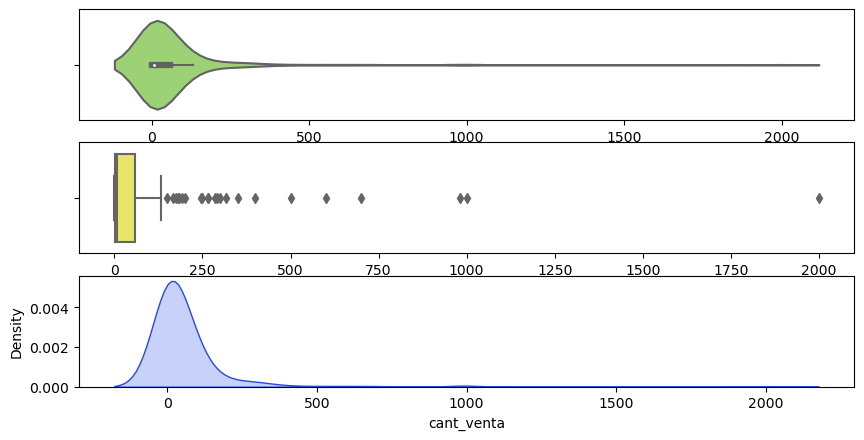

In [49]:
# Definición de los colores para los gráficos
VERDE = '#99e265' #'#5ebc0d'
AZUL = '#2649e8'  #'#17407b'
AMARILLO = '#fff952' #'#efea46'


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100, figsize=(10,5))

sns.violinplot(x='cant_venta', data=df_cantidad, color=VERDE, ax=ax1)
sns.boxplot(x='cant_venta', data=df_cantidad, color=AMARILLO, ax=ax2)
sns.kdeplot(x='cant_venta', data=df_cantidad, color=AZUL, shade=True, ax=ax3)

In [50]:
df_cantidad_min = pd.DataFrame(df_ventas.query('cantidad <= 20').cantidad.value_counts())

df_cantidad_min.reset_index(inplace=True)
df_cantidad_min.columns = ['cant_venta', 'cantidad']
df_cantidad_min.describe()


,cant_venta,cantidad
count,143.000000,143.000000
mean,3.373636,289.657343
std,4.338354,1788.386806
min,0.000000,1.000000
25%,0.515000,1.000000
50%,1.460000,2.000000
75%,4.150000,5.000000
max,20.000000,17787.000000


<AxesSubplot:xlabel='cant_venta', ylabel='Density'>

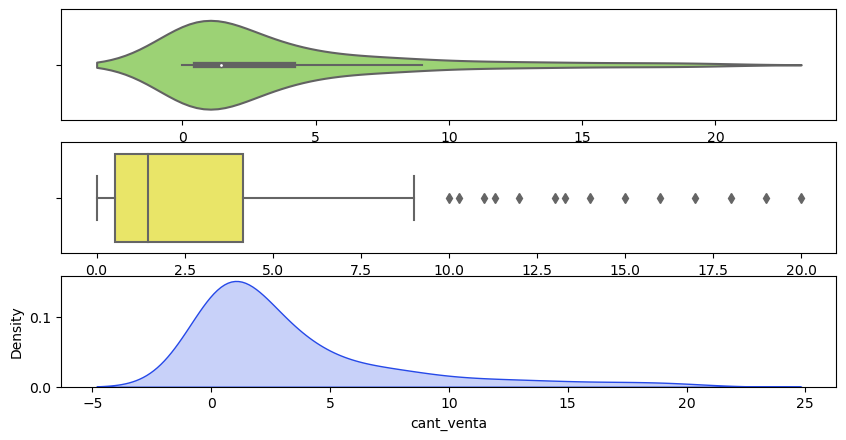

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100, figsize=(10,5))

sns.violinplot(x='cant_venta', data=df_cantidad_min, color=VERDE, ax=ax1)
sns.boxplot(x='cant_venta', data=df_cantidad_min, color=AMARILLO, ax=ax2)
sns.kdeplot(x='cant_venta', data=df_cantidad_min, color=AZUL, shade=True, ax=ax3)

In [52]:
df_cantidad_max = pd.DataFrame(df_ventas.query('cantidad > 20').cantidad.value_counts())

df_cantidad_max.reset_index(inplace=True)
df_cantidad_max.columns = ['cant_venta', 'cantidad']
df_cantidad_max.describe()

,cant_venta,cantidad
count,100.00000,100.000000
mean,149.89200,10.260000
std,252.97007,24.775607
min,21.00000,1.000000
25%,44.75000,1.000000
50%,77.00000,2.000000
75%,123.25000,6.250000
max,2000.00000,190.000000


<AxesSubplot:xlabel='cant_venta', ylabel='Density'>

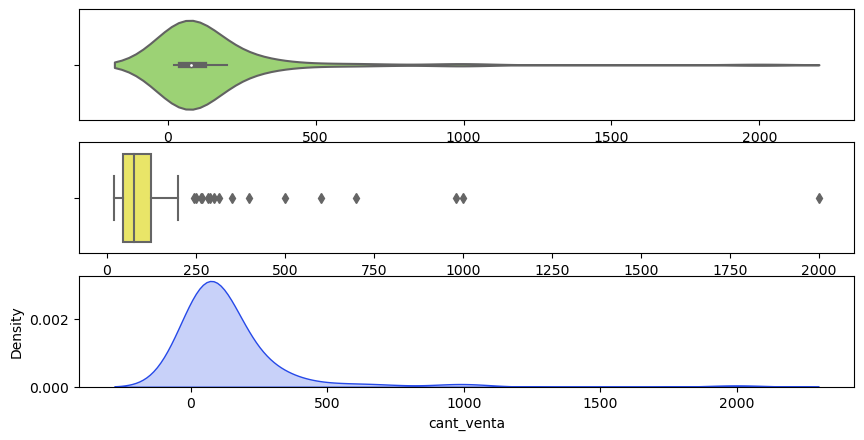

In [53]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100, figsize=(10,5))

sns.violinplot(x='cant_venta', data=df_cantidad_max, color=VERDE, ax=ax1)
sns.boxplot(x='cant_venta', data=df_cantidad_max, color=AMARILLO, ax=ax2)
sns.kdeplot(x='cant_venta', data=df_cantidad_max, color=AZUL, shade=True, ax=ax3)

In [54]:
df_cantidad_mmax = pd.DataFrame(df_ventas.query('cantidad > 500').cantidad.value_counts())

df_cantidad_mmax.reset_index(inplace=True)
df_cantidad_mmax.columns = ['cant_venta', 'cantidad']
df_cantidad_mmax.describe()

,cant_venta,cantidad
count,5.000000,5.000000
mean,1056.000000,1.600000
std,555.589777,0.547723
min,600.000000,1.000000
25%,700.000000,1.000000
50%,980.000000,2.000000
75%,1000.000000,2.000000
max,2000.000000,2.000000


<AxesSubplot:xlabel='cant_venta', ylabel='Density'>

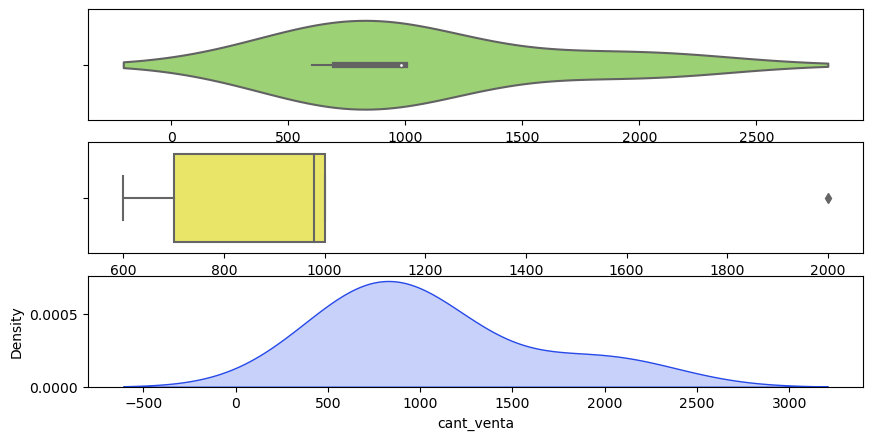

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, dpi=100, figsize=(10,5))

sns.violinplot(x='cant_venta', data=df_cantidad_mmax, color=VERDE, ax=ax1)
sns.boxplot(x='cant_venta', data=df_cantidad_mmax, color=AMARILLO, ax=ax2)
sns.kdeplot(x='cant_venta', data=df_cantidad_mmax, color=AZUL, shade=True, ax=ax3)

In [56]:
df_cantidad_moy = pd.DataFrame(df_ventas.groupby('cod').cantidad.sum()/13)

df_cantidad_moy.reset_index(inplace=True)
df_cantidad_moy.columns = ['cod', 'media_venta']
df_cantidad_moy = df_cantidad_moy.query(' media_venta > 20').sort_values('media_venta', ascending=False)
df_cantidad_moy

,cod,media_venta
152,00233,953.769231
1107,02281,274.384615
811,01228,257.076923
137,00212,217.538462
301,00432,207.615385
...,...,...
1924,04846,20.307692
93,00152,20.307692
1006,01655,20.153846
239,00348,20.076923


<AxesSubplot:xlabel='media_venta', ylabel='cod'>

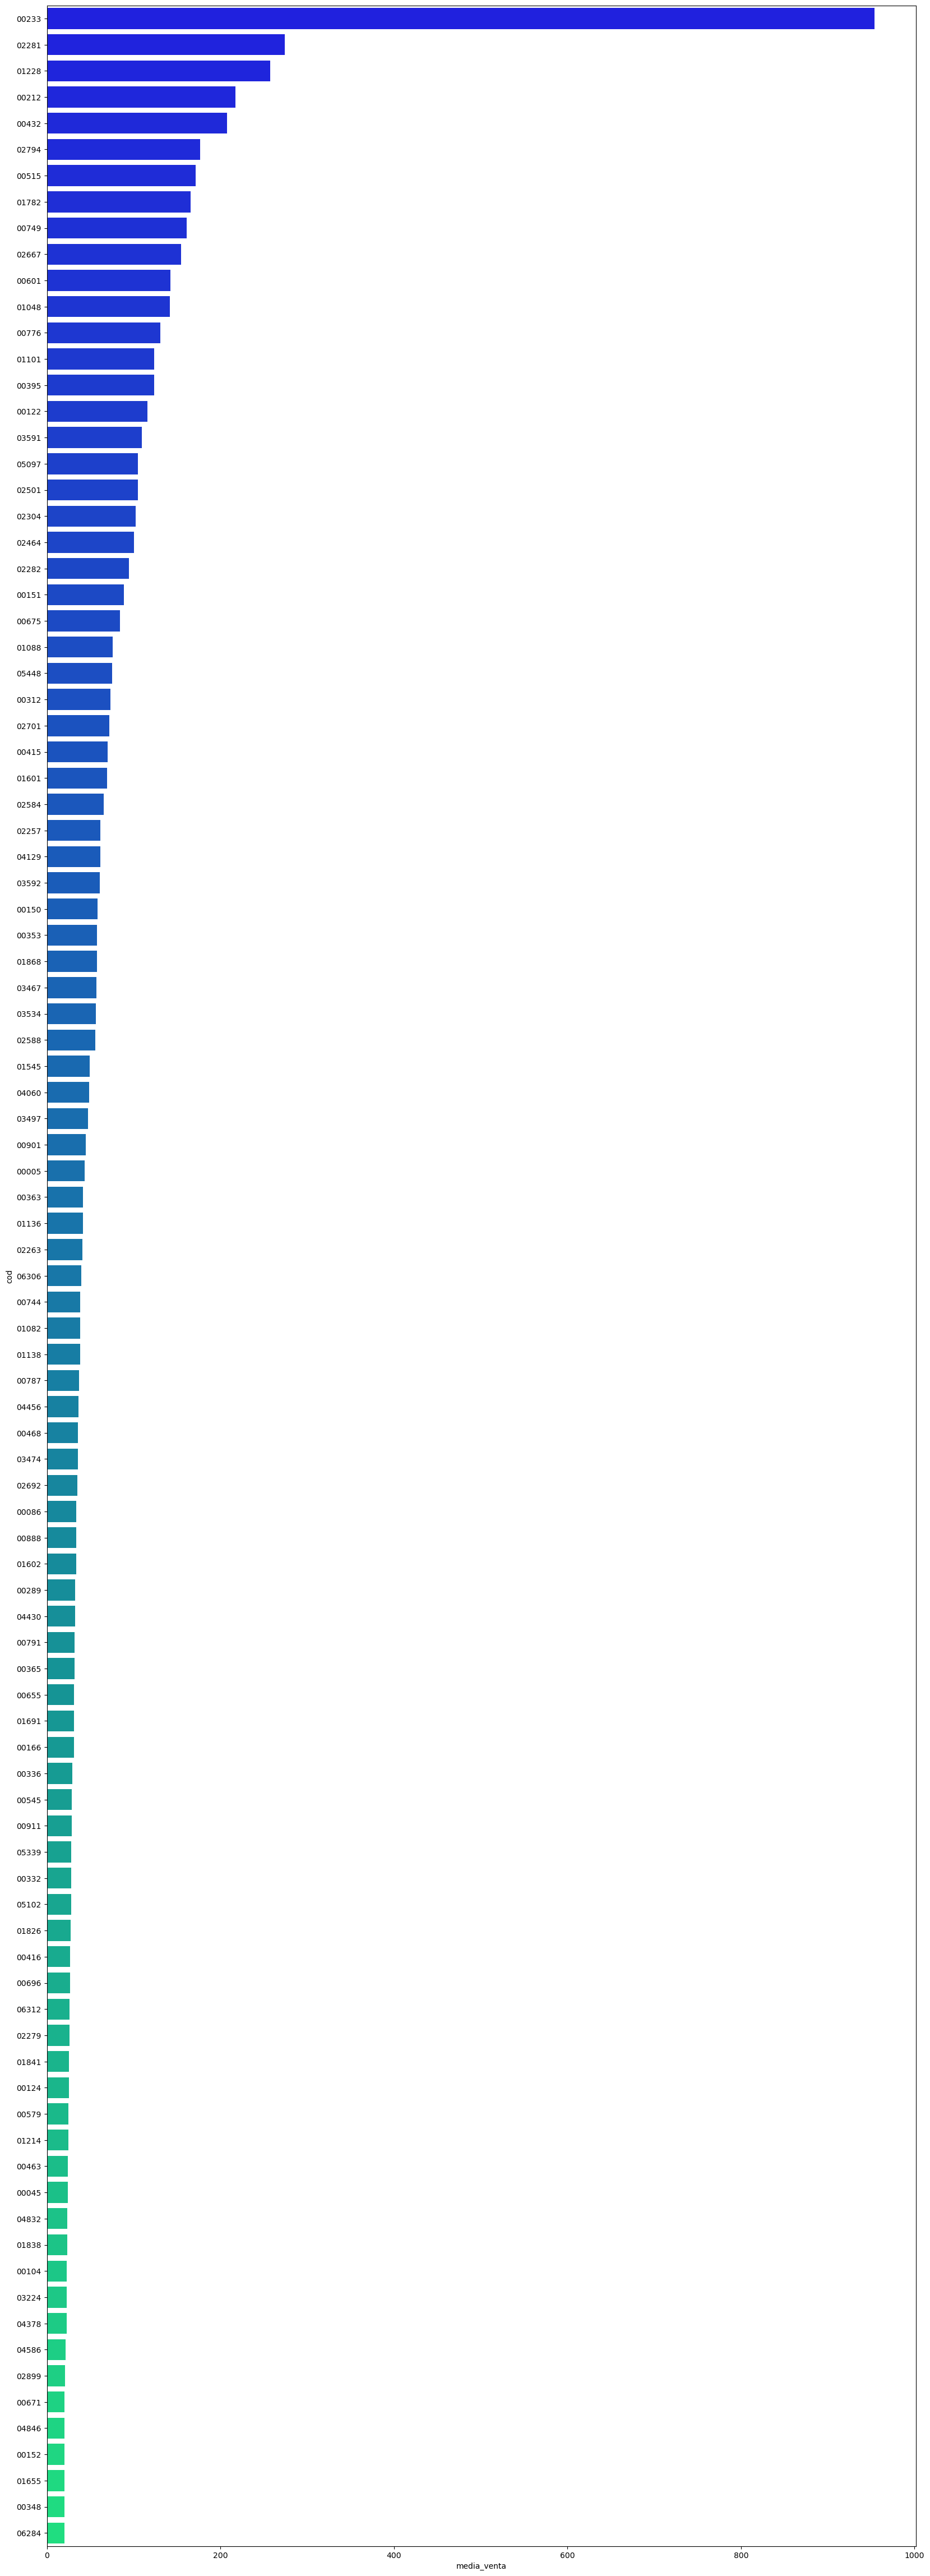

In [57]:
fig, ax = plt.subplots(1, 1, dpi=100, figsize=(20,60))

#sns.violinplot(x='cod', y='media_venta', data=df_cantidad_moy, color=VERDE, ax=ax1)
#sns.boxplot(x='cod', y='media_venta', data=df_cantidad_moy, color=AMARILLO, ax=ax2)
sns.barplot(y='cod', x='media_venta', data=df_cantidad_moy, palette='winter', ax=ax)

## Ventas por Línea de Producto

In [58]:
df_ventas_linea_prod.groupby(['cod', 'producto']).monto_dolar.sum().sort_values(ascending=False).head(25)

cod    producto                                                                     
00515  REGADOR 1/2" PLASTICO AMARILLO CON NEGRO/NEGRO DAH HAI DIAMETRO 20MTRS           4701.576451
00212  BAILARINA PUNTO BLANCO AGRO APB                                                  3539.969681
00304  MOTOR DE FUMIGAR BRIGGIES STRATION CON BOMBA FUCHU/SANCHIN 6.5 HP                3472.023576
00734  MANGUERA TUBO PEAD 160MM/6" PN10 (150PSI) GEMACA CALIDAD NORVEN (POR METRO)      3106.299050
02304  LLAVE PLASTICA 1" ROSCADA                                                        2437.711324
00716  MANGUERA PEAD 50MM/2" PN10 (150 PSI) GEMACA CALIDAD NORVEN (ROLLO DE 100 MTS)    2364.549786
00911  PUNTO SOLDADURA PEAD DESDE 32MM A 250MM/8"                                       2314.912004
00312  RIEGO ABRAZADERA PLASTICA 40MM * 3/4" AGRO/ F.P/MOM                              2228.199363
02257  RIEGO ABRAZADERA PLASTICA 50MM * 1" AGRO/FP/MOM                                  2122.889508
03497  RIEGO AB

In [59]:
df_ventas_linea_prod.groupby(['cod', 'producto']).cantidad.sum().sort_values(ascending=False).head(25)

cod    producto                                                              
00233  SOLDADURA 3/32 FINA AZUL WEST ARCO KILO(60VARILLAS)                       12399.0
02281  TORNILLO DRYWALL Nº 8*1" POR UNIDAD VERT                                   3567.0
01228  ANILLO REDUCIDO 3/4"*1/2" PLASTICO ROSCADO BLANCO FP AB3.4                 3342.0
00212  BAILARINA PUNTO BLANCO AGRO APB                                            2828.0
00432  ANILLO 3/4" PLASTICO ROSCADO                                               2699.0
02794  ARANDELA PLANA 3/8" NACIONAL TANQUE AUSTRALIANO                            2300.0
01782  CLAVO ACERO 2 1/2 RANURADO (POR UNIDAD)173 KILO                            2150.0
00749  TUERCA 3/8" GALVANIZADA HEX. NC G2 TANQUE AUSTRALIANO                      2030.0
02667  TORNILLO 3/8" * 1 1/4" HEX. NC G2 GALVANIZADO TANQUE AUSTRALIANO           2014.0
00601  SOLDADURA 3/32" GRIS FINA WEST ARCO (POR UNIDAD) 57 KILO                   1847.0
01048  CLAVO 2*10 ACERO POR UNID

In [60]:
df_ventas_linea_prod.groupby(['linea', 'producto']).monto_dolar.sum().sort_values(ascending=False).head(25)

linea                                              producto                                                                     
ASPERSORES Y REPUESTOS                             BAILARINA PUNTO BLANCO AGRO APB                                                  3539.969681
MOTORES , BOMBAS, ASPIRADORAS Y SOLDADORAS         MOTOR DE FUMIGAR BRIGGIES STRATION CON BOMBA FUCHU/SANCHIN 6.5 HP                3472.023576
MANGUERAS DE RIEGO DE POLIETILENO NEGRA            MANGUERA TUBO PEAD 160MM/6" PN10 (150PSI) GEMACA CALIDAD NORVEN (POR METRO)      3106.299050
LLAVES O VALVULAS PLASTICAS                        LLAVE PLASTICA 1" ROSCADA                                                        2437.711324
MANGUERAS DE RIEGO DE POLIETILENO NEGRA            MANGUERA PEAD 50MM/2" PN10 (150 PSI) GEMACA CALIDAD NORVEN (ROLLO DE 100 MTS)    2364.549786
CONEXIONES PLASTICAS DE RIEGO                      RIEGO ABRAZADERA PLASTICA 40MM * 3/4" AGRO/ F.P/MOM                              2228.199363
       

In [61]:
df_ventas_linea_prod.groupby(['linea', 'producto']).cantidad.sum().sort_values(ascending=False).head(25)

linea                                            producto                                                        
GENERALES                                        SOLDADURA 3/32 FINA AZUL WEST ARCO KILO(60VARILLAS)                 12399.0
ELEMENTOS DE UNION                               TORNILLO DRYWALL Nº 8*1" POR UNIDAD VERT                             3567.0
TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS  ANILLO REDUCIDO 3/4"*1/2" PLASTICO ROSCADO BLANCO FP AB3.4           3342.0
ASPERSORES Y REPUESTOS                           BAILARINA PUNTO BLANCO AGRO APB                                      2828.0
CONEXIONES PLASTICAS DE RIEGO                    ANILLO 3/4" PLASTICO ROSCADO                                         2699.0
ELEMENTOS DE UNION                               ARANDELA PLANA 3/8" NACIONAL TANQUE AUSTRALIANO                      2300.0
NO ASIGNADO                                      CLAVO ACERO 2 1/2 RANURADO (POR UNIDAD)173 KILO                      2150.0
ELEMENTOS D

In [62]:
df_ventas_fecha_linea = df_ventas_linea_prod.groupby(['fecha', 'linea']).monto_dolar.sum() #.sort_values(ascending=False).head(10)

In [63]:
df_ventas_fecha_linea = df_ventas_fecha_linea.reset_index()
#df_ventas_fecha_linea = df_ventas_fecha_linea.set_index('fecha')
df_ventas_fecha_linea

,fecha,linea,monto_dolar
0,2021-01-05,ALAMBRES Y MALLAS,14.317035
1,2021-01-05,ASPERSORES Y REPUESTOS,78.926155
2,2021-01-05,CHUCHERIAS,3.954794
3,2021-01-05,CONEXIONES GALVANIZADAS Y CROMADAS,51.972449
4,2021-01-05,CONEXIONES PLASTICAS DE RIEGO,169.377226
...,...,...,...
6237,2022-02-15,"NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS",78.734205
6238,2022-02-15,NO ASIGNADO,3.296296
6239,2022-02-15,PVC TUBERIAS Y ACCESORIOS DE AN,1.013072
6240,2022-02-15,TUBERIA DE COBRE Y CONEXIONES DE BRONCE,10.130719


In [64]:
alt.data_transformers.disable_max_rows()

lineas = alt.Chart(df_ventas_fecha_linea).mark_line().encode(
    x='fecha:T',
    y='monto_dolar:Q',
    color=alt.Color('linea:N'),
    column='linea:N',
    tooltip=[
        alt.Tooltip('fecha:T', title='Fecha'),
        alt.Tooltip('linea:N', title='Línea de producto'),
        alt.Tooltip('monto_dolar:Q', title='Ventas $ por Línea')
    ]).properties(width=800, height=300)

lineas

alt.Chart(...)

In [65]:
df_ventas_linea_prod.groupby(['linea']).cantidad.sum().sort_values(ascending=False)

linea
ELEMENTOS DE UNION                                   27730.96
GENERALES                                            26003.75
CONEXIONES PLASTICAS DE RIEGO                        16828.00
ELECTRICIDAD                                         10439.65
NO ASIGNADO                                           8260.88
TUBERIAS AGUAS BLANCAS PLASTICAS Y GALVANIZADAS       7808.85
NIPLES DE HIERRO GALVANIZADO, CROMADO Y PLASTICOS     7226.00
ASPERSORES Y REPUESTOS                                4937.00
CONEXIONES GALVANIZADAS Y CROMADAS                    4713.00
LLAVES O VALVULAS PLASTICAS                           3514.00
PVC TUBERIAS Y ACCESORIOS DE AN                       3313.00
CHUCHERIAS                                            2166.00
GRIFERIA GENERAL                                      1545.00
MANGUERAS GENERALES NO DE POLIETILENO                 1201.89
CONSTRUCCIÓN                                          1012.82
SEGURIDAD & HIGIENE                                    839.00
HE

## 8. Afluencia de Clientes<a name="afluencia-cl"></a>

Usamos el número de facturas por día de la semana para determinar los días en que hay mayor cantidad de clientes. 

Aunque no todas las personas que entran a la tienda compran, contar el número de ventas (facturas) puede dar una idea del tráfico o cantidad de clientes en un día y hora dados.

In [66]:
# Utilizamos nunique para contabilizar sólo una vez cada referencia de factura
# Descomponemos la fecha

df_n_fact = df_ventas.loc[:,['fecha_comp', 'fecha', 'num']]

df_n_fact['mes'] = df_n_fact.fecha_comp.dt.month
df_n_fact['año'] = df_n_fact.fecha_comp.dt.year

df_n_fact['dia_semana'] = df_n_fact.fecha_comp.dt.weekday
df_n_fact['dia_mes'] = df_n_fact.fecha_comp.dt.day

df_n_fact['hora'] = df_n_fact.fecha_comp.dt.hour

df_n_fact.sample(25)

,fecha_comp,fecha,num,mes,año,dia_semana,dia_mes,hora
23930,2021-02-18 10:06:00,2021-02-18,2021-0000001794-fa,2,2021,3,18,10
8798,2020-03-08 11:08:00,2020-03-08,2020-0000002377-fa,3,2020,6,8,11
27285,2021-05-22 07:45:00,2021-05-22,2021-0000004654-fa,5,2021,5,22,7
38620,2021-08-12 10:15:00,2021-08-12,2021-0000001609-ne,8,2021,3,12,10
11653,2022-01-06 09:55:00,2022-01-06,2022-0000006210-ne,1,2022,3,6,9
7676,2020-02-03 10:27:00,2020-02-03,2020-0000001100-fa,2,2020,0,3,10
21423,2021-07-07 14:26:00,2021-07-07,2021-0000000448-ne,7,2021,2,7,14
22108,2021-08-30 11:48:00,2021-08-30,2021-0000005926-fa,8,2021,0,30,11
15005,2022-02-05 09:18:00,2022-02-05,2022-0000007580-ne,2,2022,5,5,9
3085,2020-08-28 11:18:00,2020-08-28,2020-0000001106-ne,8,2020,4,28,11


### 8.A Afluencia de Clientes por Día de la Semana<a name="afluencia-cl-dia"></a>

In [67]:
# Sólo las ventas en los días de semana
df_cl_fecha_semana = df_n_fact.query('dia_semana < 5').groupby('fecha').num.nunique()
df_cl_fecha_semana.describe()

count    529.000000
mean      44.869565
std       11.258330
min        5.000000
25%       38.000000
50%       44.000000
75%       52.000000
max       89.000000
Name: num, dtype: float64

In [68]:
# Sólo las ventas los sábados
df_cl_fecha_we = df_n_fact.query('dia_semana == 5').groupby('fecha').num.nunique()
df_cl_fecha_we.describe()

count    61.000000
mean     24.344262
std       9.518202
min       1.000000
25%      18.000000
50%      26.000000
75%      31.000000
max      42.000000
Name: num, dtype: float64

In [69]:
# N° de facturas para cada día de la semana
df_cl_dias = df_n_fact.pivot_table('num', index='dia_semana', aggfunc={'num':'nunique' }) 
df_cl_dias = df_cl_dias.reset_index()
df_cl_dias

,dia_semana,num
0,0,4677
1,1,4940
2,2,4870
3,3,4699
4,4,4550
5,5,1485
6,6,205


<AxesSubplot:xlabel='dia_semana', ylabel='num'>

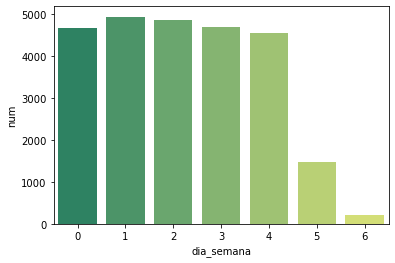

In [70]:
sns.barplot(data=df_cl_dias, x='dia_semana', y='num', palette='summer')

### 8.B Afluencia de Clientes por Hora<a name="afluencia-cl-hora"></a>

In [71]:
# Horas de más afluencia
df_cl_hora = df_n_fact.pivot_table('num', index='hora', aggfunc={'num':'nunique' }) 
df_cl_hora = df_cl_hora.reset_index()
df_cl_hora

,hora,num
0,0,190
1,1,10
2,2,7
3,3,5
4,4,11
5,5,10
6,6,15
7,7,70
8,8,2359
9,9,3943


<AxesSubplot:xlabel='hora', ylabel='num'>

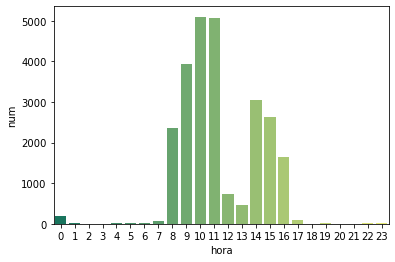

In [72]:
sns.barplot(data=df_cl_hora, x='hora', y='num', palette='summer')

In [73]:
# Horas de más afluencia entre semana

df_cl_hora_sin_we = df_n_fact.query('dia_semana < 5')

df_cl_hora_sin_we = df_cl_hora_sin_we.pivot_table('num', index='hora', aggfunc={'num':'nunique' }) 
df_cl_hora_sin_we = df_cl_hora_sin_we.reset_index()
df_cl_hora_sin_we

,hora,num
0,0,180
1,1,10
2,2,7
3,3,5
4,4,11
5,5,6
6,6,4
7,7,64
8,8,2138
9,9,3586


<AxesSubplot:xlabel='hora', ylabel='num'>

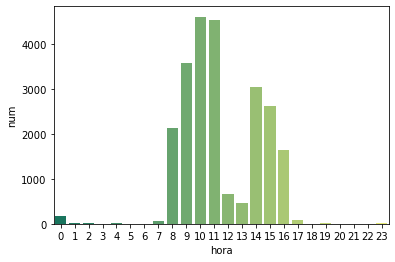

In [74]:
sns.barplot(data=df_cl_hora_sin_we, x='hora', y='num', palette='summer')

### 8.C Conclusiones<a name="afluencia-cl-conclusion"></a>

1. En promedio, se hacen 41 ventas al día (número de facturas): 43 en días de semana y 23 los fines de semana. Aproximadamente 6 facturas por hora (43 / 7 por las 7 horas que abre la tienda cada día)
2. Martes y miércoles son los días de mayor afluencia de clientes, seguido del lunes
3. A partir del jueves, la afluencia disminuye, en particular el fin de semana
4. Las horas de mayor afluencia son entre las 10am y las 12pm, y en la tarde de 2pm a 3pm

**Es recomendable garantizar la presencia y disponibilidad de todo el personal los lunes, martes y miércoles y en particular todos los días de 10am a 12pm**